# German (Fasttext + BiLSTM + GeLU)

In [77]:
import codecs
import csv
import json
import logging
import os
import re
import sys
import time
from itertools import product

import dill
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
import wandb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
#from simpletransformers.classification import MultiLabelClassificationModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
def clean_text(string):
    output = string.strip()
    # replacements = (("“", '"'), ("”", '"'), ("//", ""), ("«", '"'), ("»",'"'))
    replacements = (
      ("“", ''), ("”", ''), ("//", ""), ("«", ''), ("»",''), (",", ''),
      (";", ''), (".", ''),
    #   ("?", ''), ("¿", ''), ("¡", ''), ("!", ''), ("-", ' '),
    )
    for replacement in replacements:
        output = output.replace(*replacement)
    # Any sequence of two or more spaces should be converted into one space
    output = re.sub(r'(?is)\s+', ' ', output)
    return output.strip()


def metric2binary(meter, pad=11):
    return ([1 if syllable == "+" else 0 for syllable in meter] + [0] * (11 - len(meter)))[:pad]


def label2metric(label):
    return "".join("+" if l else "-" for l in label)


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## German

In [8]:
# German
ge = (pd
    .read_csv("po-emo-metricalizer.csv")
    .rename(columns={"verse": "text", "annotated_pattern": "meter", "metricalizer_pattern": "sota"})
    .assign(
        text=lambda x: x["text"].apply(clean_text),
        length=lambda x: x["meter"].str.len()
    )
    .drop_duplicates("text")
    .query("length in (5, 6, 7, 8, 9, 10, 11)")
)
#ge["labels"] = ge.meter.apply(metric2binary)
pos_names = [f"pos{i}" for i in range(1, int(ge.meter.str.len().max()) + 1)]
pos_labels = ge.meter.apply(metric2binary)
ge["labels"] = pos_labels
ge[pos_names] = pos_labels.tolist()
ge[pos_names] = ge[pos_names].astype(float)

ge_train_eval, ge_test = train_test_split(ge, test_size=0.15, random_state=42)
ge_train, ge_val = train_test_split(
    ge_train_eval[["text"] + pos_names], test_size=0.176, random_state=42)

In [5]:
ge.head()

,text,meter,sota,length,labels,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9,pos10,pos11
0,Edel sei der Mensch,+---+,-+--+,5,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Unterscheidet ihn,--+--,+-+-+,5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Von allen Wesen,-+-+-,-+-+-,5,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Heil den unbekannten,+-+---,+-+-+-,6,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Ihnen gleiche der Mensch!,+-+--+,+-+--+,6,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]",1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#vectors_filename = "glove-sbwc.i25.vec"
#vectors_filename = "SBW-vectors-300-min5.vec"
#vectors_filename = "fasttext-SUC-embeddings-l-model.vec"
vectors_filename = "cc.de.300.vec"

if True:  # not os.path.isfile("embeddings_index.pkl"):
    def get_coefs(word, *vector):
        return word, np.asarray(vector, dtype='float32')
    with open(f"/home/jupyter/{vectors_filename}") as vec_file:
        embeddings_index = dict(
            get_coefs(*line.strip().split())
            for idx, line in enumerate(tqdm(vec_file))
            if idx != 0  # First line continas counts
        )
    #with open("embeddings_index.pkl", "wb") as embeddings_file:
    #    dill.dump(embeddings_index, embeddings_file)
else:
    with open("embeddings_index.pkl", "rb") as embeddings_file:
        embeddings_index = dill.load(embeddings_file)

2000001it [04:25, 7531.05it/s]


In [18]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
del all_embs
emb_mean, emb_std

(0.0005482614, 0.044953596)

In [20]:
embed_size = 300  # how big is each word vector
max_features = 1730  # how many unique words to use (i.e num rows in embedding vector)
maxlen = 24  # max number of words per input
y_train = ge_train[pos_names].values
y_test = ge_test[pos_names].values
y_val = ge_val[pos_names].values

In [21]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(ge_train.text.values))
tokenized_train = tokenizer.texts_to_sequences(ge_train.text.values)
tokenized_val = tokenizer.texts_to_sequences(ge_val.text.values)
tokenized_test = tokenizer.texts_to_sequences(ge_test.text.values)
X_train = pad_sequences(tokenized_train, maxlen=maxlen, padding="post")
X_val = pad_sequences(tokenized_val, maxlen=maxlen, padding="post")
X_test = pad_sequences(tokenized_test, maxlen=maxlen, padding="post")

In [22]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        break
    embedding_vector = embeddings_index.get(word, embeddings_index.get(word.lower()))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [53]:
inp = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
print(model.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 24, 300)           519000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 24, 100)           140400    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 11)              

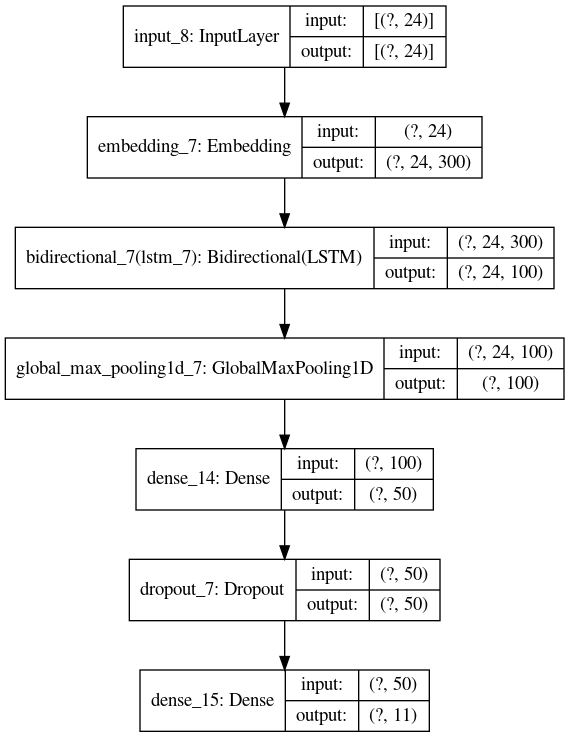

In [48]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [49]:
ge_train.iloc[0].text

'"Jetzt wird er ans Kreuz geschlagen"'

In [50]:
X_train[0]

array([128,  45,   7, 129, 192, 408,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [54]:
history04 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=4,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/4
23/23 [==============================] - 4s 155ms/step - loss: 0.6224 - accuracy: 0.4308 - val_loss: 0.5371 - val_accuracy: 0.6118
Epoch 2/4
23/23 [==============================] - 3s 138ms/step - loss: 0.5243 - accuracy: 0.5395 - val_loss: 0.5106 - val_accuracy: 0.6118
Epoch 3/4
23/23 [==============================] - 3s 135ms/step - loss: 0.5112 - accuracy: 0.4788 - val_loss: 0.5081 - val_accuracy: 0.6053
Epoch 4/4
23/23 [==============================] - 3s 137ms/step - loss: 0.5094 - accuracy: 0.4562 - val_loss: 0.5060 - val_accuracy: 0.6118


In [55]:
model.evaluate(X_test, y_test, verbose=1)

5/5 [==============================] - 0s 12ms/step - loss: 0.5081 - accuracy: 0.5724


[0.5080882906913757, 0.5723684430122375]

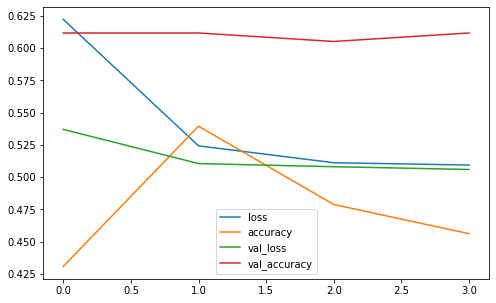

In [58]:
pd.DataFrame(history04.history).plot(figsize=(8,5))

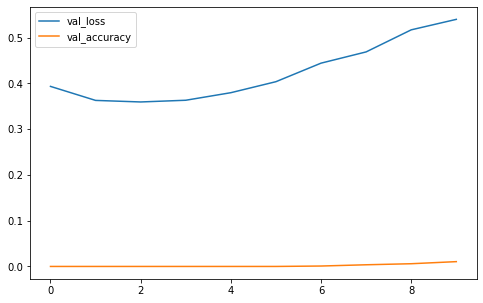

In [29]:
pd.DataFrame(history10.history)[["val_loss", "val_accuracy"]].plot(figsize=(8,5))

In [59]:
history100 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/100
23/23 [==============================] - 3s 148ms/step - loss: 0.5081 - accuracy: 0.4760 - val_loss: 0.5034 - val_accuracy: 0.5461
Epoch 2/100
23/23 [==============================] - 3s 144ms/step - loss: 0.5039 - accuracy: 0.4703 - val_loss: 0.5003 - val_accuracy: 0.5066
Epoch 3/100
23/23 [==============================] - 3s 145ms/step - loss: 0.4967 - accuracy: 0.4929 - val_loss: 0.4961 - val_accuracy: 0.5987
Epoch 4/100
23/23 [==============================] - 3s 142ms/step - loss: 0.4888 - accuracy: 0.5325 - val_loss: 0.4942 - val_accuracy: 0.5197
Epoch 5/100
23/23 [==============================] - 3s 139ms/step - loss: 0.4837 - accuracy: 0.4873 - val_loss: 0.4932 - val_accuracy: 0.4013
Epoch 6/100
23/23 [==============================] - 3s 142ms/step - loss: 0.4758 - accuracy: 0.4661 - val_loss: 0.4899 - val_accuracy: 0.5329
Epoch 7/100
23/23 [==============================] - 3s 139ms/step - loss: 0.4681 - accuracy: 0.4873 - val_loss: 0.4906 - val_accuracy: 0.5132

In [60]:
model.evaluate(X_test, y_test, verbose=1)

5/5 [==============================] - 0s 12ms/step - loss: 1.0119 - accuracy: 0.4539


[1.011904001235962, 0.45394736528396606]

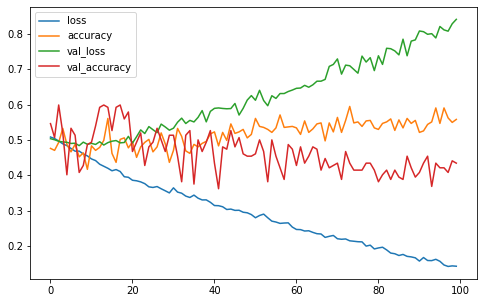

In [61]:
pd.DataFrame(history100.history).plot(figsize=(8,5))

---

In [69]:
inputs = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inputs)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation=tfa.activations.gelu)(x)
#x = TimeDistributed(Dense(50, activation=tfa.activations.gelu))(x)  # a dense layer as suggested by neuralNer

x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)

model_gelu = Model(inputs=inputs, outputs=x)
model_gelu.compile(loss='binary_crossentropy', optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), metrics=['accuracy'])

model_gelu.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 24)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 24, 300)           519000    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 24, 100)           140400    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 11)              

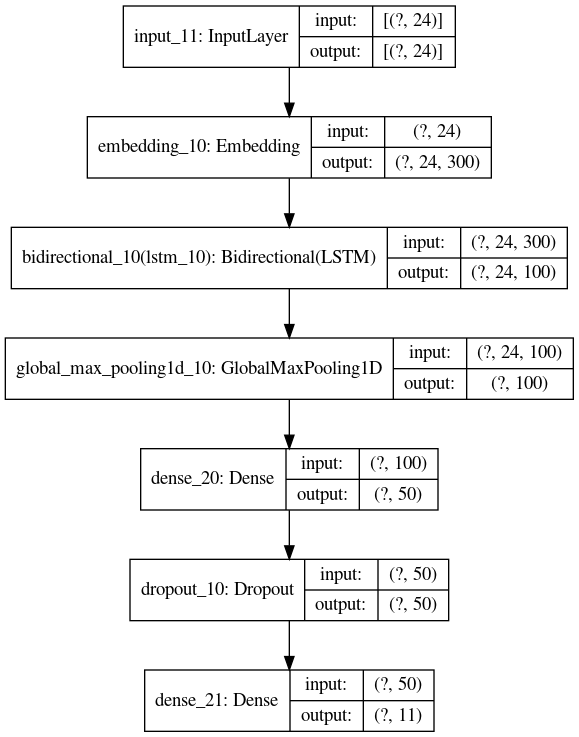

In [70]:
tf.keras.utils.plot_model(model_gelu, show_shapes=True)

In [71]:
history10_gelu = model_gelu.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/10
23/23 [==============================] - 4s 179ms/step - loss: 0.6274 - accuracy: 0.1271 - val_loss: 0.5414 - val_accuracy: 0.0855
Epoch 2/10
23/23 [==============================] - 4s 156ms/step - loss: 0.5159 - accuracy: 0.4237 - val_loss: 0.5110 - val_accuracy: 0.5921
Epoch 3/10
23/23 [==============================] - 4s 159ms/step - loss: 0.5044 - accuracy: 0.3771 - val_loss: 0.5034 - val_accuracy: 0.5987
Epoch 4/10
23/23 [==============================] - 4s 160ms/step - loss: 0.4894 - accuracy: 0.4534 - val_loss: 0.5007 - val_accuracy: 0.5395
Epoch 5/10
23/23 [==============================] - 4s 156ms/step - loss: 0.4534 - accuracy: 0.5014 - val_loss: 0.5114 - val_accuracy: 0.3553
Epoch 6/10
23/23 [==============================] - 4s 158ms/step - loss: 0.4080 - accuracy: 0.5452 - val_loss: 0.5285 - val_accuracy: 0.3618
Epoch 7/10
23/23 [==============================] - 4s 161ms/step - loss: 0.3705 - accuracy: 0.6257 - val_loss: 0.5429 - val_accuracy: 0.4934
Epoch 

In [72]:
model_gelu.evaluate(X_test, y_test, verbose=1)

5/5 [==============================] - 0s 12ms/step - loss: 0.6519 - accuracy: 0.4671


[0.6518579721450806, 0.46710526943206787]

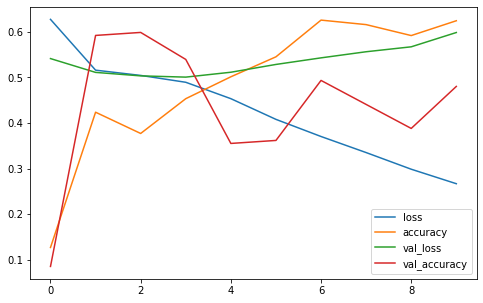

In [73]:
pd.DataFrame(history10_gelu.history).plot(figsize=(8,5))

In [74]:
history100_gelu = model_gelu.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/100
23/23 [==============================] - 4s 156ms/step - loss: 0.2450 - accuracy: 0.5678 - val_loss: 0.6101 - val_accuracy: 0.4211
Epoch 2/100
23/23 [==============================] - 4s 158ms/step - loss: 0.2078 - accuracy: 0.6370 - val_loss: 0.6332 - val_accuracy: 0.4342
Epoch 3/100
23/23 [==============================] - 4s 158ms/step - loss: 0.1893 - accuracy: 0.5636 - val_loss: 0.6797 - val_accuracy: 0.4803
Epoch 4/100
23/23 [==============================] - 4s 157ms/step - loss: 0.1657 - accuracy: 0.5706 - val_loss: 0.6900 - val_accuracy: 0.4276
Epoch 5/100
23/23 [==============================] - 4s 157ms/step - loss: 0.1457 - accuracy: 0.5523 - val_loss: 0.7365 - val_accuracy: 0.4737
Epoch 6/100
23/23 [==============================] - 4s 159ms/step - loss: 0.1267 - accuracy: 0.5452 - val_loss: 0.7670 - val_accuracy: 0.4671
Epoch 7/100
23/23 [==============================] - 4s 163ms/step - loss: 0.1130 - accuracy: 0.5636 - val_loss: 0.8097 - val_accuracy: 0.4539

In [75]:
model_gelu.evaluate(X_test, y_test, verbose=1)

5/5 [==============================] - 0s 12ms/step - loss: 1.9050 - accuracy: 0.2237


[1.9050192832946777, 0.22368420660495758]

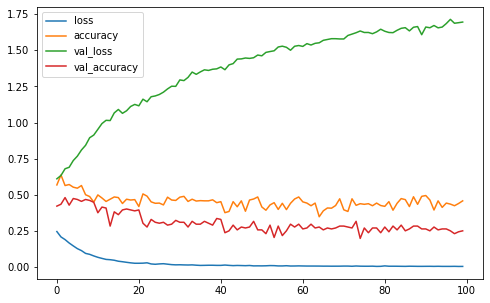

In [76]:
pd.DataFrame(history100_gelu.history).plot(figsize=(8,5))

---

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 24)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 24, 300)           519000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 24, 100)           140400    
_________________________________________________________________
lstm_12 (LSTM)               (None, 24, 50)            30200     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)              

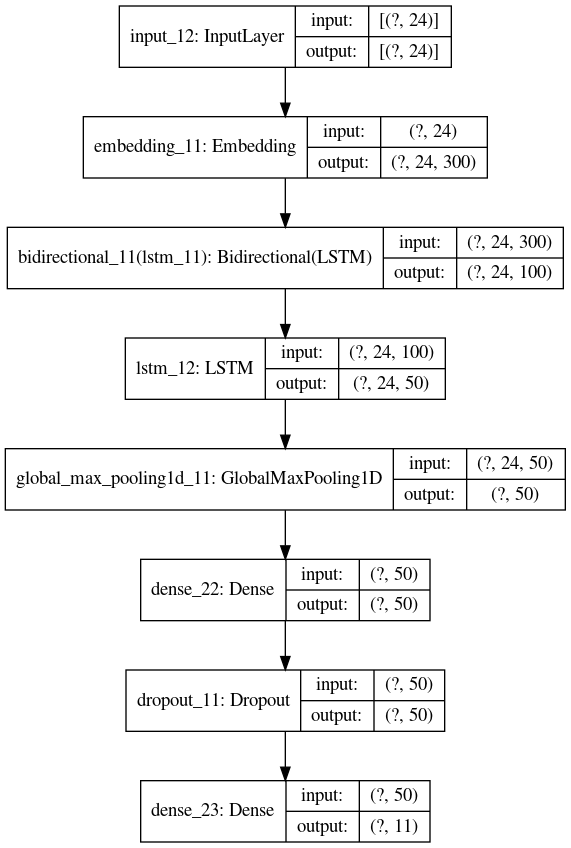

In [78]:
inputs = Input(shape=maxlen)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inputs)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation=tfa.activations.gelu)(x)
#x = TimeDistributed(Dense(50, activation=tfa.activations.gelu))(x)  # a dense layer as suggested by neuralNer
x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)

model_2lstm = Model(inputs=inputs, outputs=x)
model_2lstm.compile(loss='binary_crossentropy', optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), metrics=['accuracy'])

model_2lstm.summary()
tf.keras.utils.plot_model(model_2lstm, show_shapes=True)

In [79]:
history10_2lstm = model_2lstm.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/10
23/23 [==============================] - 6s 254ms/step - loss: 0.6092 - accuracy: 0.1497 - val_loss: 0.5232 - val_accuracy: 0.6118
Epoch 2/10
23/23 [==============================] - 5s 231ms/step - loss: 0.5138 - accuracy: 0.3672 - val_loss: 0.5078 - val_accuracy: 0.6118
Epoch 3/10
23/23 [==============================] - 5s 230ms/step - loss: 0.5088 - accuracy: 0.4379 - val_loss: 0.5090 - val_accuracy: 0.6118
Epoch 4/10
23/23 [==============================] - 5s 231ms/step - loss: 0.5046 - accuracy: 0.4322 - val_loss: 0.5063 - val_accuracy: 0.6118
Epoch 5/10
23/23 [==============================] - 5s 232ms/step - loss: 0.4955 - accuracy: 0.4661 - val_loss: 0.4998 - val_accuracy: 0.5921
Epoch 6/10
23/23 [==============================] - 5s 238ms/step - loss: 0.4650 - accuracy: 0.3347 - val_loss: 0.5096 - val_accuracy: 0.2105
Epoch 7/10
23/23 [==============================] - 6s 239ms/step - loss: 0.4132 - accuracy: 0.2288 - val_loss: 0.5082 - val_accuracy: 0.4408
Epoch 

In [80]:
model_2lstm.evaluate(X_test, y_test, verbose=1)

5/5 [==============================] - 0s 16ms/step - loss: 0.5976 - accuracy: 0.3487


[0.5976136922836304, 0.3486842215061188]

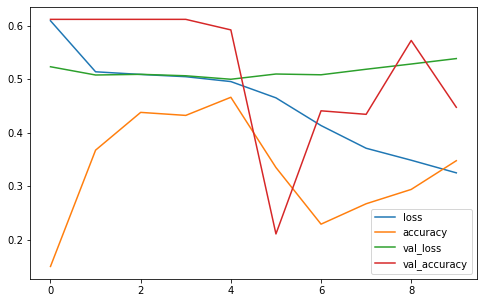

In [81]:
pd.DataFrame(history10_2lstm.history).plot(figsize=(8,5))

In [82]:
history100_2lstm = model_2lstm.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    verbose=1,
)  # validation_split=0.15

Epoch 1/100
23/23 [==============================] - 5s 228ms/step - loss: 0.2968 - accuracy: 0.3136 - val_loss: 0.5563 - val_accuracy: 0.4934
Epoch 2/100
23/23 [==============================] - 5s 230ms/step - loss: 0.2809 - accuracy: 0.3983 - val_loss: 0.5770 - val_accuracy: 0.4211
Epoch 3/100
23/23 [==============================] - 6s 242ms/step - loss: 0.2589 - accuracy: 0.3489 - val_loss: 0.6191 - val_accuracy: 0.3289
Epoch 4/100
23/23 [==============================] - 6s 239ms/step - loss: 0.2488 - accuracy: 0.4025 - val_loss: 0.6304 - val_accuracy: 0.2434
Epoch 5/100
23/23 [==============================] - 5s 228ms/step - loss: 0.2282 - accuracy: 0.3799 - val_loss: 0.6730 - val_accuracy: 0.2434
Epoch 6/100
23/23 [==============================] - 5s 224ms/step - loss: 0.2141 - accuracy: 0.4322 - val_loss: 0.7077 - val_accuracy: 0.1842
Epoch 7/100
23/23 [==============================] - 5s 231ms/step - loss: 0.1994 - accuracy: 0.4054 - val_loss: 0.7370 - val_accuracy: 0.1776

In [83]:
model_2lstm.evaluate(X_test, y_test, verbose=1)

5/5 [==============================] - 0s 16ms/step - loss: 2.1958 - accuracy: 0.1974


[2.1958136558532715, 0.19736842811107635]

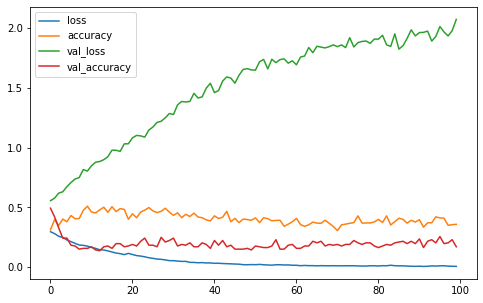

In [84]:
pd.DataFrame(history100_2lstm.history).plot(figsize=(8,5))